# Image Captioning with Attention



## Overview
We design and train an Image captioning network with an Attention mechanism to generate a sequence that describes the image. 

##  Versions of packages

`python 3.8.11`, `torch==1.8.2` and `torchvision==0.9.2`.

In [ ]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.7.12 (default, Sep 10 2021, 00:21:48) 
torch 1.10.0+cu111
torchvision 0.11.1+cu111


# Dataset
We use [Flickr8k](https://www.kaggle.com/dataset/e1cd22253a9b23b073794872bf565648ddbe4f17e7fa9e74766ad3707141adeb) dataset from Alexander Mamaev.

`flickr8k` contains 2 folders and 1 txt:
- `images/`: contains **8092** images for training.
- `test_examples/`: contains **5** images for testing.
- `captions.txt`: the file_names and their captions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip -qq ./drive/MyDrive/flickr8k.zip

replace flickr8k/captions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os  s
import pandas as pd  
import spacy  
from torch.nn.utils.rnn import pad_sequence 
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
import numpy as np
import torch.nn as nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Processing & DataLoader

In [ ]:
spacy_eng = spacy.load("en_core_web_sm")

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} # index to string
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3} # string to index
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)] #lowercase all the words
    
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4 # 0-3 have already been used

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)

In [ ]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim = 0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first = False, padding_value = self.pad_idx)

        return imgs, targets

In [ ]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size = 32,
    num_workers = 8,
    shuffle = True,
    pin_memory = True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform = transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory,
        collate_fn = MyCollate(pad_idx = pad_idx),
    )

    return loader, dataset


### Data Augmentation 

In [ ]:
transform = transforms.Compose(
  [
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
  ]
)

In [ ]:
train_loader, dataset = get_loader(
  root_folder="flickr8k/images/",
  annotation_file="flickr8k/captions.txt",
  transform=transform,
  num_workers=0,
)

########################
dataL = iter(train_loader)
imgs, captions = dataL.next()
print("Shape of the imgs : ", imgs.shape)
print("Shape of the captions : ", captions.shape)

Shape of the imgs :  torch.Size([32, 3, 224, 224])
Shape of the captions :  torch.Size([23, 32])


# Build Model


In [ ]:
class EncoderAttentionCNN(nn.Module):
    def __init__(self):
        super(EncoderAttentionCNN, self).__init__()
        
        model_ = models.resnet101(pretrained=True)
        
        for param in model_.parameters():
            param.requires_grad_(False)
        
        self.pretrained = nn.Sequential(*(list(model_.children())[:-2]))
        # self.embed = nn.Linear(model_.fc.in_features, embed_size) # 全連接接到嵌入

    def forward(self, images):

        features = self.pretrained(images)
        # out = torch.flatten(out, 1) 
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
   

        return features 
        #(batch_size, num_pixels, encoder_dim) ,if pretrained = resnet50: (batch_size ,49, 2048)

### Attention Module

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim


        # Attention layers

        self.decoder_att = nn.Linear(decoder_dim, attention_dim) 
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.full_att = nn.Linear(attention_dim, 1)


    def forward(self, features, hidden_state):
      # features (batch_size, num_pixels, encoder_dim)
      # hidden_state (batch_size, decoder_dim)

        atten_1 = self.encoder_att(features)  
        atten_2 = self.decoder_att(hidden_state)
        
        combined_atten = self.full_att(self.relu(atten_1 + atten_2.unsqueeze(1))).squeeze(2)  
        
        # alpha:(batch_size, num_pixels)        
        alpha = self.softmax(combined_atten)

        # attention_weights:#(batch_size, features_dim)
        attention_weights = (features * alpha.unsqueeze(2)).sum(dim=1)

        return alpha, attention_weights     

### Attention RNN Decoder

In [ ]:
class DecoderAttentionRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        """
        :param attention_dim: size of attention network
        :param embed_dim: embedding size
        :param decoder_dim: size of decoder's RNN
        :param vocab_size: size of vocabulary
        :param encoder_dim: feature size of encoded images
        :param dropout: dropout
        """
        
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        
        #  Decoder Attention RNN layers                 #
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True) 

        
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        
        self.drop = nn.Dropout(drop_prob)
        self.init_weights()

    def init_weights(self):

        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fcn.bias.data.fill_(0)
        self.fcn.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):

        mean_encoder_out = encoder_out.mean(dim=1)
        
        # get the hidden_state and the cell
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)
        # size (batch_size, decoder_dim) 
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
        
        for s in range(seq_length):
            
            # Get the attention output from attention module
            alpha, attention_weight = self.attention(features, h)
            
            lstm_input = torch.cat((embeds[:, s], attention_weight), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas


    #Testing Phase
    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)

        alphas = []
        
        #start input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)
        
        captions = []
        
        for i in range(max_len):

            # Get attention output from the attention module
            alpha, attention_weight = self.attention(features, h)
            
        
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], attention_weight), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)      
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions], alphas

### Combine the Encoder with Decoder

In [ ]:
class CNNtoAttentionRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderAttentionCNN()
        self.decoder = DecoderAttentionRNN(
            embed_size = embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim = attention_dim,
            encoder_dim = encoder_dim,
            decoder_dim = decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

# Traning

In [ ]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

In [ ]:
#init model
model = CNNtoAttentionRNN(
    embed_size=300,
    vocab_size = len(dataset.vocab),
    attention_dim=256,
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 2
print_every = 100

for epoch in range(1,num_epochs+1):   
    
    for idx, (image, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        image, captions = image.to(device), captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()
        
        captions = captions.permute(1, 0)
        
        # Feed forward
        outputs, attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

#         if (idx+1)%print_every == 0:
#             print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
    stat_vals = 'Epochs [%d/%d] ------- Loss [%.4f] ' %( epoch, num_epochs, loss.item() )
    print(stat_vals)

Epochs [1/2] ------- Loss [2.8020] 


Epochs [2/2] ------- Loss [2.6631] 


## Testing

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0], title = caption)
    
    return caps, alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    
    for l in range(len_result):

        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.8, extent=img.get_extent())      

    plt.tight_layout()
    plt.show()
    
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0)) 
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

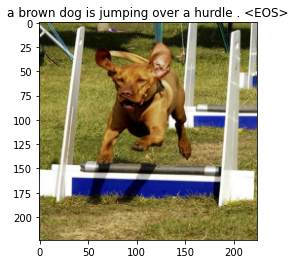

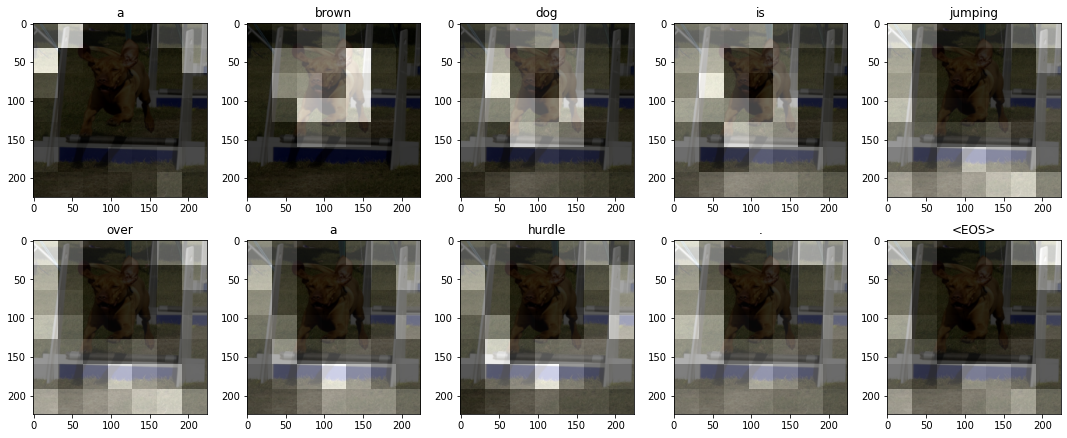

In [ ]:
dataiter = iter(train_loader)
images, _ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)